In [ ]:
%%capture
!pip install qiskit[visualization]
!pip install qiskit-ibm-runtime
!pip install qiskit_aer

In [ ]:
api = ''
crn = ''

## $\mathcal{G}(\mathcal{V},\mathcal{E})$

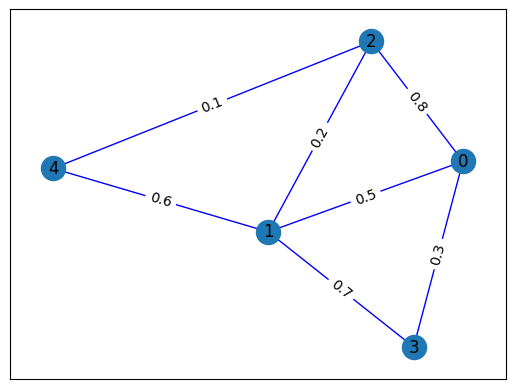

In [ ]:
import networkx as nx

G = nx.Graph()
E = [(0, 1, 0.5), (1, 2, 0.2), (0, 2, 0.8), (3, 0, 0.3), (1, 3, 0.7), (2, 4, 0.1), (4, 1, 0.6)]
G.add_weighted_edges_from(E)

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='b')
edges = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edges);

## Equivariant Quantum Circuit

One qubit per node

In [ ]:
from qiskit import QuantumCircuit

n = G.number_of_nodes()
ansatz = QuantumCircuit(n)

### Preparation $|s\rangle=$ $|+\rangle^{\otimes n}$

In [ ]:
for i in range(n):
    ansatz.h(i)

### Layers

In [ ]:
from qiskit.circuit import Parameter

L = 3
beta = [Parameter(f'beta_{l}') for l in range(L)]
gamma = [Parameter(f'gamma_{l}') for l in range(L)]

$U_N(\mathcal{V}, \beta) = \bigotimes_{i \in V} R_x^{(i)}(\beta_l)$

In [ ]:
def U_N(q, n, beta_l):
    q.barrier(label='U_N')
    for i in range(n):
        # R_x gate on every qubit
        q.rx(beta_l, i)

Hamiltonian $H_\mathcal{G} = \sum_{(i,j)\in\mathcal{E}} \varepsilon_{i,j}\sigma_z^{(i)} \sigma_z^{(j)}$

In [ ]:
from qiskit.quantum_info import SparsePauliOp

def H_G(edges):
    data = []
    coeffs = []
    for (u, v), w in edges.items():
        pauli = ['I'] * n
        pauli[u] = 'Z'
        pauli[v] = 'Z'
        data.append(''.join(pauli[::-1]))
        coeffs.append(w)
    return SparsePauliOp(data, coeffs)

$U_\mathcal{G}(\mathcal{E},γ_j) = exp(-i \gamma_j H_\mathcal{G})$

In [ ]:
def U_G(q, edges, gamma_l):
    q.barrier(label='U_G')
    for (u, v), w in edges.items():
        # RZZ(angle, i, j) = exp(-i theta Z_i Z_j / 2)
        theta = 2 * gamma_l * w
        q.rzz(theta, u, v)

### Ansatz

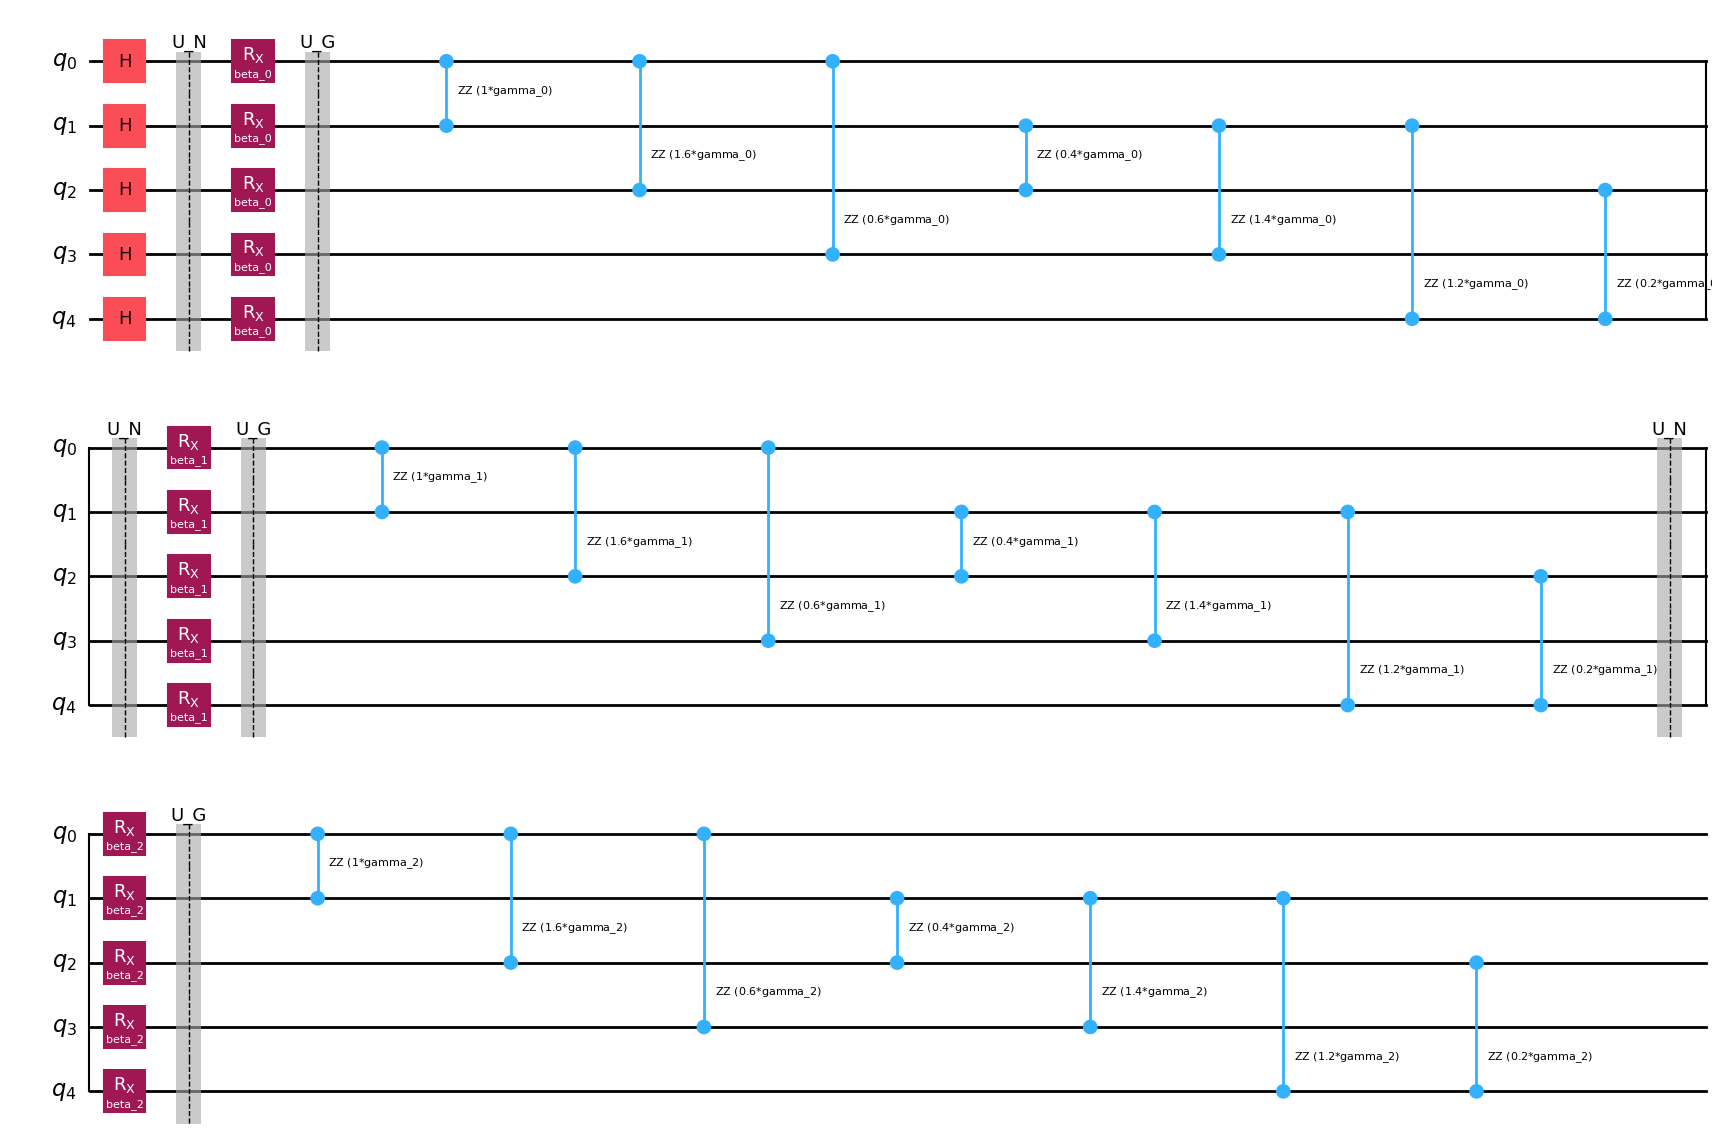

In [ ]:
for l in range(L):
    U_N(ansatz, n, beta[l])
    U_G(ansatz, edges, gamma[l])

ansatz.draw('mpl')

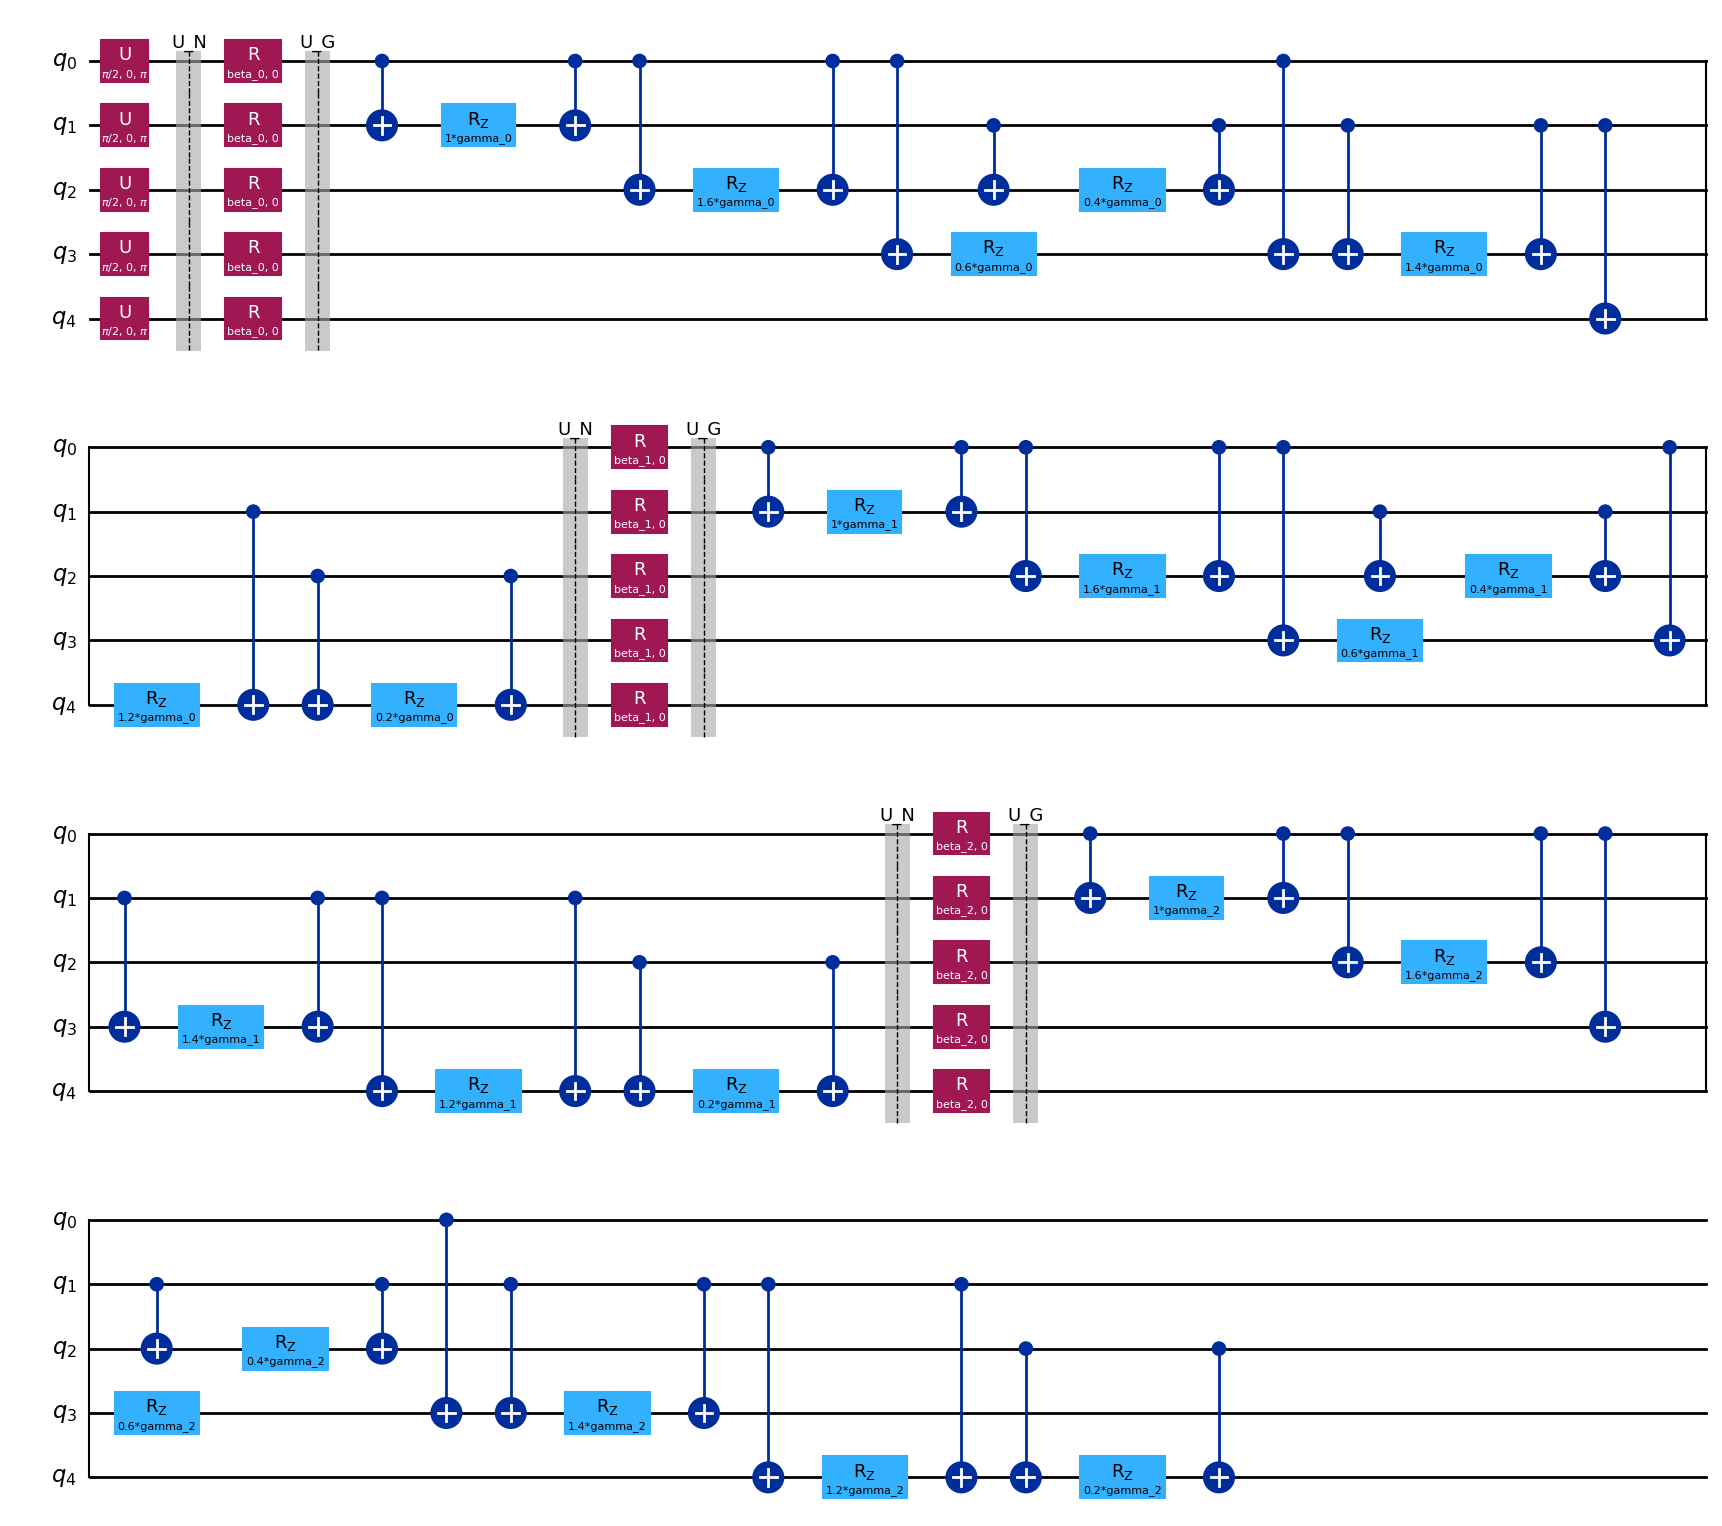

In [ ]:
ansatz.decompose().draw("mpl", style="iqp")

### Backend

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=api,
    instance=crn
)

#backend = service.least_busy(operational=True, simulator=False)
#print(backend)

qiskit_runtime_service._discover_account:WARNING:2025-12-17 11:46:59,684: Loading account with the given token. A saved account will not be used.


In [ ]:
from qiskit_aer import AerSimulator

backend = AerSimulator()

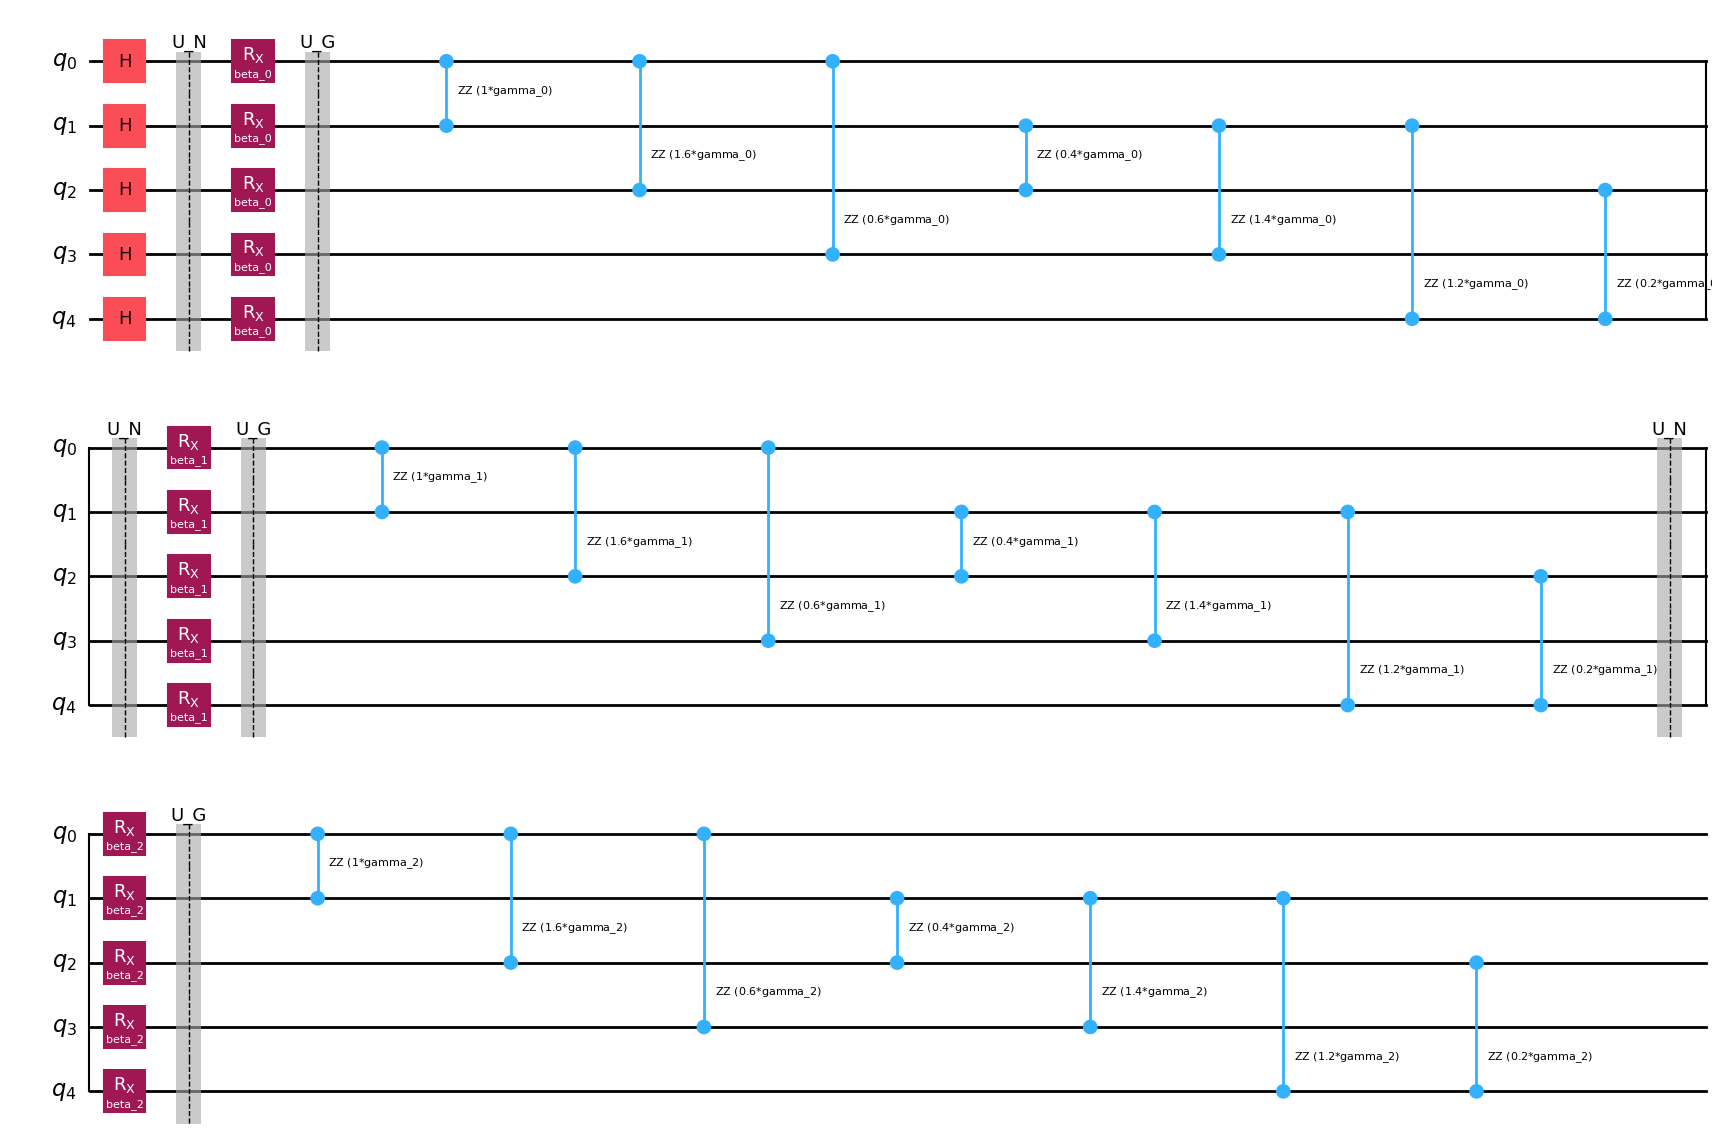

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

### Hamiltonian

In [ ]:
hamiltonian = H_G(edges)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

### Expectation

In [ ]:
cost_history = {
    'prev_vector': None,
    'iters': 0,
    'costs': [],
}

# Return zero-point energy
def cost(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    job = estimator.run(pubs=[pub])
    # Expectation value
    E_0 = job.result()[0].data.evs[0]

    cost_history['iters'] += 1
    cost_history['prev_vector'] = params
    cost_history['costs'].append(E_0)
    print(f"Iter {cost_history['iters']} -> ^E_0 = {E_0} -- ^θ = {params}")

    return E_0

### $\theta_0$

In [ ]:
import numpy as np

#theta_0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
theta_0 = [0.1] * ansatz.num_parameters
#theta_0 = [ 5.0742646,  -4.00289154, -0.45600185,  0.52120633,  1.03795952,  1.64300395 ]

### Classical optimization

In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Session
from scipy.optimize import minimize

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost,
        theta_0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method='Powell',
        tol=1e-3,
        options={'maxiter': 200},
    )

Iter 1 -> ^E_0 = 0.22874000000000003 -- ^θ = [0.1 0.1 0.1 0.1 0.1 0.1]
Iter 2 -> ^E_0 = 0.23531999999999997 -- ^θ = [0.1 0.1 0.1 0.1 0.1 0.1]
Iter 3 -> ^E_0 = 0.2263 -- ^θ = [1.1 0.1 0.1 0.1 0.1 0.1]
Iter 4 -> ^E_0 = 0.21106 -- ^θ = [2.718034 0.1      0.1      0.1      0.1      0.1     ]
Iter 5 -> ^E_0 = 0.23353999999999997 -- ^θ = [5.33606803 0.1        0.1        0.1        0.1        0.1       ]
Iter 6 -> ^E_0 = 0.2039 -- ^θ = [3.71803398 0.1        0.1        0.1        0.1        0.1       ]
Iter 7 -> ^E_0 = 0.23407999999999998 -- ^θ = [4.33606797 0.1        0.1        0.1        0.1        0.1       ]
Iter 8 -> ^E_0 = 0.22808 -- ^θ = [3.35623059 0.1        0.1        0.1        0.1        0.1       ]
Iter 9 -> ^E_0 = 0.21903999999999998 -- ^θ = [3.71803398 0.1        0.1        0.1        0.1        0.1       ]
Iter 10 -> ^E_0 = 0.36268000000000006 -- ^θ = [3.71803398 1.1        0.1        0.1        0.1        0.1       ]
Iter 11 -> ^E_0 = -0.007659999999999999 -- ^θ = [ 3.71803

### Theoretical value

In [ ]:
A = np.array(hamiltonian)
eigenvalues, eigenvectors = np.linalg.eigh(A)
E_0 = min(eigenvalues)

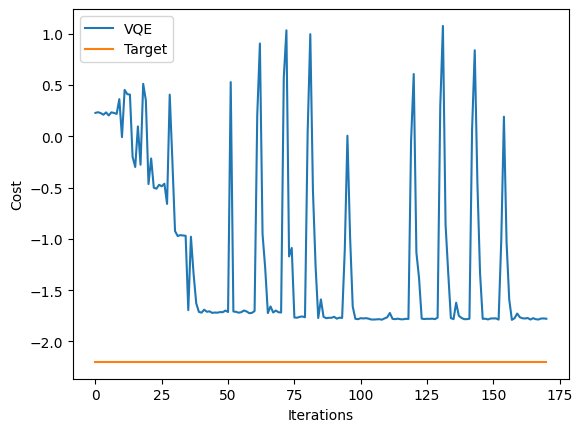

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x = np.linspace(0, 10, 171)
ax.plot(range(cost_history["iters"]), cost_history["costs"], label="VQE")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.plot(np.full_like(x, E_0), label="Target")
plt.legend()
plt.draw()

In [ ]:
ansatz_isa.depth()

22